In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- Transformlar ---
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # hafif augment; SSIM'i bozmaz
    transforms.ToTensor(),                   # 0–1 aralığı
])
test_transform = transforms.ToTensor()       # değerlendirme için sadece ToTensor

# --- Datasetler ---
train_data = datasets.CIFAR10(
    root='./data', train=True, transform=train_transform, download=True
)
test_data = datasets.CIFAR10(
    root='./data', train=False, transform=test_transform, download=True
)

# --- DataLoader'lar ---
BATCH_SIZE = 128
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

In [ ]:
import torch

# Bir batch al
dataiter = iter(train_loader)
images, labels = next(dataiter)          # images: [B,C,32,32], 0–1

print("images.shape:", images.shape)

# %50 random pixel-level maske (kanallar arası aynı)
def make_random_pixel_mask(x, keep_prob=0.5):
    """
    x: [B,C,H,W] tensörü (0–1)
    keep_prob: pikselin korunma olasılığı (0.5 => %50 siyah kayıp)
    döner: mask [B,C,H,W], 1=koru, 0=siyah yap
    """
    B, C, H, W = x.shape
    pix_mask = (torch.rand(B, 1, H, W, device=x.device) < keep_prob).float()
    return pix_mask.expand(-1, C, -1, -1)

mask = make_random_pixel_mask(images, keep_prob=0.5)
masked_images = images * mask            # kayıp pikseller tamamen siyah (0)

print("mask.shape:", mask.shape)
print("masked_images.shape:", masked_images.shape)

images.shape: torch.Size([128, 3, 32, 32])
mask.shape: torch.Size([128, 3, 32, 32])
masked_images.shape: torch.Size([128, 3, 32, 32])


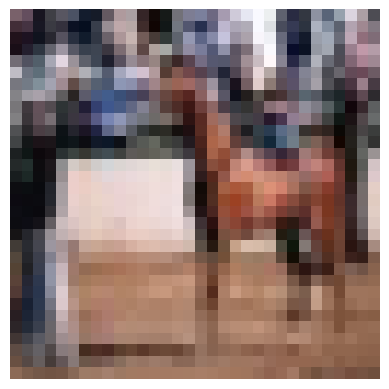

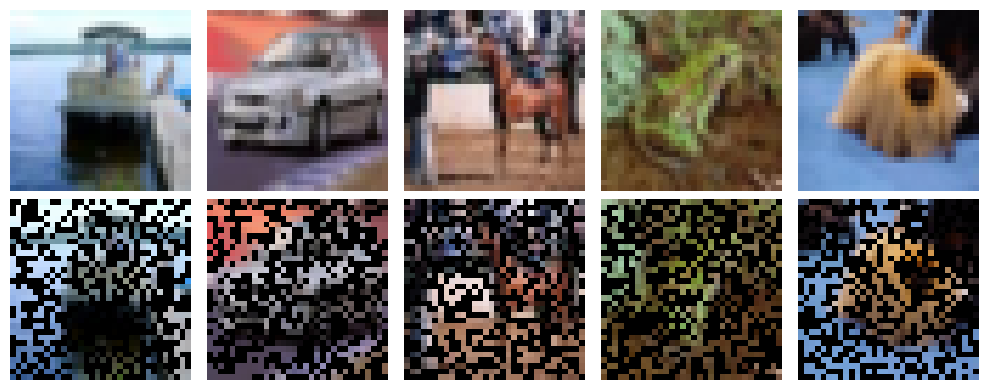

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow_tensor(img):
    """
    img: [C,H,W] torch.Tensor (0–1) ya da [H,W,C] np.array
    """
    if torch.is_tensor(img):
        img = img.detach().cpu().float()
        if img.ndim == 3:  # [C,H,W] -> [H,W,C]
            img = img.permute(1, 2, 0)
        img = img.numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_original_and_masked(original, masked, n=5):
    """
    original, masked: [B,C,H,W] tensörleri
    """
    n = min(n, original.shape[0])
    fig, axs = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        o = original[i].detach().cpu().permute(1,2,0).numpy()
        m = masked[i].detach().cpu().permute(1,2,0).numpy()
        axs[0, i].imshow(np.clip(o,0,1)); axs[0, i].axis('off')
        axs[1, i].imshow(np.clip(m,0,1)); axs[1, i].axis('off')
    axs[0, 0].set_ylabel("Orijinal")
    axs[1, 0].set_ylabel("Maskeli")
    plt.tight_layout()
    plt.show()

# tek görsel göster
imshow_tensor(images[2])

# çoklu karşılaştırma (asıl istediğimiz)
show_original_and_masked(images, masked_images, n=5)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetAutoEncoder(nn.Module):
    """
    ResNet18 encoder + skip'li decoder (U-Net tarzı).
    CIFAR-10 (32x32) için ayarlı: conv1 -> 3x3/stride1, maxpool yok.
    """
    def __init__(self, freeze_encoder: bool = False):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # CIFAR-10 için ilk katmanı 3x3/stride1 yapıyoruz, maxpool kullanmıyoruz
        backbone.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.enc1 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu)  # 32x32, 64
        self.enc2 = backbone.layer1                                            # 32x32, 64
        self.enc3 = backbone.layer2                                            # 16x16,128
        self.enc4 = backbone.layer3                                            # 8x8,  256
        self.enc5 = backbone.layer4                                            # 4x4,  512

        if freeze_encoder:
            for m in [self.enc1, self.enc2, self.enc3, self.enc4, self.enc5]:
                for p in m.parameters():
                    p.requires_grad_(False)

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        self.up5  = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 4->8
        self.dec5 = conv_block(512 + 256, 256)

        self.up4  = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 8->16
        self.dec4 = conv_block(256 + 128, 128)

        self.up3  = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 16->32
        self.dec3 = conv_block(128 +  64,  64)

        self.dec2 = conv_block(64 + 64, 64)  # 32x32 refine (enc1 skip)

        self.out_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)   # 32x32, 64
        x2 = self.enc2(x1)  # 32x32, 64
        x3 = self.enc3(x2)  # 16x16,128
        x4 = self.enc4(x3)  # 8x8,  256
        x5 = self.enc5(x4)  # 4x4,  512

        y = self.up5(x5)               # 8x8
        y = self.dec5(torch.cat([y, x4], dim=1))

        y = self.up4(y)                # 16x16
        y = self.dec4(torch.cat([y, x3], dim=1))

        y = self.up3(y)                # 32x32
        y = self.dec3(torch.cat([y, x2], dim=1))

        y = self.dec2(torch.cat([y, x1], dim=1))  # 32x32
        y = self.out_conv(y)
        return torch.sigmoid(y)  # [0,1]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = ResNetAutoEncoder().to(device)

# --- OPTİMİZER & SCHEDULER ---
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

# (Opsiyonel) LR scheduler – istersen epoch sonunda scheduler.step() çağıracağız
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=20)  # 20 epoch örnek

# --- LOSS BİLEŞENLERİ ---
# Mask-odaklı L1 kullanacağız
criterion_l1 = nn.L1Loss(reduction="none")

try:
    from pytorch_msssim import ms_ssim as _ms_ssim
    USE_MS_SSIM = True
except Exception:
    _ms_ssim = None
    USE_MS_SSIM = False

def compute_inpainting_loss(pred, target, mask):
    """
    pred, target: [B,C,H,W] 0–1
    mask: [B,C,H,W], 1=KORU, 0=SİYAH (kayıp)
    """
    drop_mask  = 1.0 - mask                 # 1=kayıp piksel
    l1_full    = criterion_l1(pred, target) # [B,C,H,W]

    # 1) Kayıp bölgede L1
    l1_inpaint = (l1_full * drop_mask).mean()
    # 2) Görünen bölgede L1 (düşük ağırlık)
    l1_visible = (l1_full * mask).mean()

    # 3) Kenar vurgusu (kayıp sınırlarında ekstra ağırlık)
    k = torch.ones(1,1,3,3, device=mask.device)
    border = (F.conv2d(drop_mask[:, :1], k, padding=1) > 0).float() - drop_mask[:, :1]
    border = border.clamp(0,1).expand_as(drop_mask)
    l1_border = (l1_full * border).mean()

    loss = l1_inpaint + 0.1*l1_visible + 0.2*l1_border

    # 4) (Varsa) MS-SSIM ile algısal terim
    if USE_MS_SSIM:
        ssim_val = _ms_ssim(pred, target, data_range=1.0, size_average=True)  # 0..1
        loss = loss + 0.2*(1.0 - ssim_val)

    return loss

In [ ]:
import torch
import torch.nn.functional as F

num_epochs   = 30
loss_values  = []

if 'make_random_pixel_mask' not in globals():
    def make_random_pixel_mask(x, keep_prob=0.5):
        B, C, H, W = x.shape
        pix_mask = (torch.rand(B, 1, H, W, device=x.device) < keep_prob).float()
        return pix_mask.expand(-1, C, -1, -1)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Curriculum: kolaydan zora — ilk başta daha az kayıp (%30), sonra %50
    keep_start, keep_end = 0.70, 0.50
    t = epoch / max(1, (num_epochs - 1))
    keep_prob = keep_start + (keep_end - keep_start) * t  # lineer geçiş

    for images, _ in train_loader:
        images = images.to(device).float()              # [B,C,32,32], 0–1
        mask   = make_random_pixel_mask(images, keep_prob=keep_prob)  # GPU'da üret
        masked_images = images * mask

        # İleri
        optimizer.zero_grad(set_to_none=True)
        pred = model(masked_images)
        if pred.shape[-2:] != images.shape[-2:]:
            pred = F.interpolate(pred, size=images.shape[-2:], mode='bilinear', align_corners=False)

        # Kayıp (mask-odaklı L1 + sınır + (opsiyonel) MS-SSIM)
        loss = compute_inpainting_loss(pred, images, mask)

        # Geri
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # opsiyonel ama stabil
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)

    # (Opsiyonel) LR scheduler varsa
    if 'scheduler' in globals():
        scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  keep_prob={keep_prob:.2f}  loss={epoch_loss:.4f}")

Epoch [1/30]  keep_prob=0.70  loss=0.0222
Epoch [2/30]  keep_prob=0.69  loss=0.0144
Epoch [3/30]  keep_prob=0.69  loss=0.0134
Epoch [4/30]  keep_prob=0.68  loss=0.0130
Epoch [5/30]  keep_prob=0.67  loss=0.0125
Epoch [6/30]  keep_prob=0.67  loss=0.0122
Epoch [7/30]  keep_prob=0.66  loss=0.0120
Epoch [8/30]  keep_prob=0.65  loss=0.0119
Epoch [9/30]  keep_prob=0.64  loss=0.0119
Epoch [10/30]  keep_prob=0.64  loss=0.0119
Epoch [11/30]  keep_prob=0.63  loss=0.0118
Epoch [12/30]  keep_prob=0.62  loss=0.0119
Epoch [13/30]  keep_prob=0.62  loss=0.0121
Epoch [14/30]  keep_prob=0.61  loss=0.0121
Epoch [15/30]  keep_prob=0.60  loss=0.0123
Epoch [16/30]  keep_prob=0.60  loss=0.0125
Epoch [17/30]  keep_prob=0.59  loss=0.0126
Epoch [18/30]  keep_prob=0.58  loss=0.0129
Epoch [19/30]  keep_prob=0.58  loss=0.0131
Epoch [20/30]  keep_prob=0.57  loss=0.0134
Epoch [21/30]  keep_prob=0.56  loss=0.0138
Epoch [22/30]  keep_prob=0.56  loss=0.0141
Epoch [23/30]  keep_prob=0.55  loss=0.0143
Epoch [24/30]  keep_

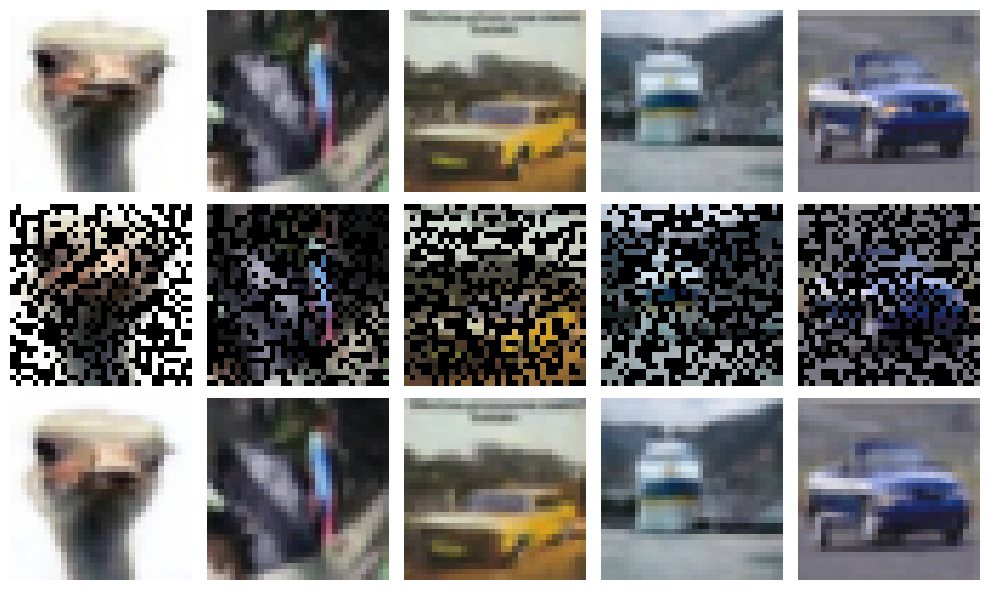

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt

model.eval()


if 'images' not in globals() or 'masked_images' not in globals():
    dataiter = iter(test_loader if 'test_loader' in globals() else train_loader)
    images, _ = next(dataiter)                      # [B,C,32,32], 0–1
    # %50 siyah piksel maske (kanallar arası aynı)
    if 'make_random_pixel_mask' not in globals():
        def make_random_pixel_mask(x, keep_prob=0.5):
            B, C, H, W = x.shape
            return (torch.rand(B, 1, H, W, device=x.device) < keep_prob).float().expand(-1, C, -1, -1)
    mask = make_random_pixel_mask(images, keep_prob=0.5)
    masked_images = images * mask


with torch.no_grad():
    imgs_dev  = images.to(device).float()
    masked_dev = masked_images.to(device).float()
    outputs = model(masked_dev)
    # (emniyet) boyut farklıysa 32x32'ye getir
    if outputs.shape[-2:] != imgs_dev.shape[-2:]:
        outputs = torch.nn.functional.interpolate(outputs, size=imgs_dev.shape[-2:], mode='bilinear', align_corners=False)


images_cpu         = imgs_dev.cpu()
masked_images_cpu  = masked_dev.cpu()
outputs_cpu        = outputs.cpu()

def show_images(original, masked, reconstructed, n=5):
    n = min(n, original.shape[0])
    fig, axs = plt.subplots(3, n, figsize=(n*2, 6))
    for i in range(n):
        o = original[i].permute(1,2,0).numpy()
        m = masked[i].permute(1,2,0).numpy()
        r = reconstructed[i].permute(1,2,0).numpy()
        axs[0,i].imshow(np.clip(o,0,1)); axs[0,i].axis('off')
        axs[1,i].imshow(np.clip(m,0,1)); axs[1,i].axis('off')
        axs[2,i].imshow(np.clip(r,0,1)); axs[2,i].axis('off')
    axs[0,0].set_ylabel("Orijinal")
    axs[1,0].set_ylabel("Maskeli")
    axs[2,0].set_ylabel("Tahmin")
    plt.tight_layout(); plt.show()

show_images(images_cpu, masked_images_cpu, outputs_cpu, n=5)

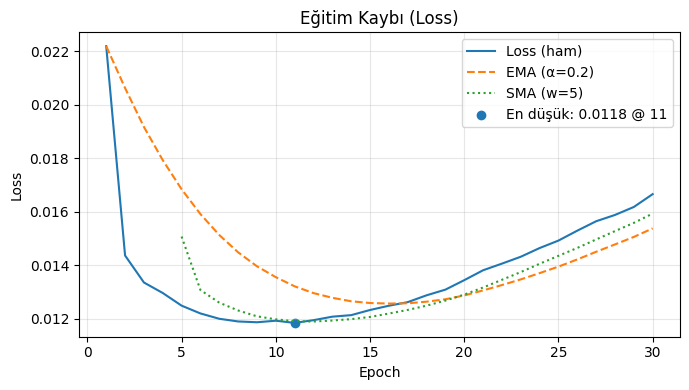

Kaydedildi: training_loss.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

if len(loss_values) == 0:
    print("loss_values boş görünüyor. Önce eğitimi çalıştırmalısın.")
else:
    epochs = np.arange(1, len(loss_values) + 1)
    lv = np.array(loss_values, dtype=float)

    # EMA (exponential moving average)
    def ema(x, alpha=0.2):
        y = np.empty_like(x, dtype=float)
        y[0] = x[0]
        for i in range(1, len(x)):
            y[i] = alpha * x[i] + (1 - alpha) * y[i-1]
        return y

    ema_vals = ema(lv, alpha=0.2)

    # SMA (simple moving average)
    w = 5
    sma = None
    if len(lv) >= w:
        sma = np.convolve(lv, np.ones(w)/w, mode='valid')

    # En düşük loss noktası
    min_idx = int(np.argmin(lv))
    min_epoch = epochs[min_idx]
    min_val = lv[min_idx]

    plt.figure(figsize=(7,4))
    plt.plot(epochs, lv, label="Loss (ham)")
    plt.plot(epochs, ema_vals, linestyle="--", label="EMA (α=0.2)")
    if sma is not None:
        plt.plot(epochs[w-1:], sma, linestyle=":", label=f"SMA (w={w})")
    plt.scatter([min_epoch], [min_val], marker="o", label=f"En düşük: {min_val:.4f} @ {min_epoch}")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Eğitim Kaybı (Loss)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("training_loss.png", dpi=200, bbox_inches="tight")
    plt.show()

    print("Kaydedildi: training_loss.png")

In [ ]:
import torch, math, numpy as np

# Güvenlik: tensörler [0,1] aralığında ve aynı boyutta olsun
imgs = torch.clamp(images, 0, 1)
outs = torch.clamp(outputs, 0, 1)

# --- MSE / MAE (batch) ---
mse_per = torch.mean((outs - imgs) ** 2, dim=(1,2,3))
mae_per = torch.mean(torch.abs(outs - imgs), dim=(1,2,3))

mse_mean = mse_per.mean().item()
mae_mean = mae_per.mean().item()

# --- PSNR (batch) ---
mse_safe = torch.clamp(mse_per, min=1e-12)
psnr_per = 10.0 * torch.log10(1.0 / mse_safe)
psnr_mean = psnr_per.mean().item()

# --- SSIM (opsiyonel, skimage varsa) ---
try:
    from skimage.metrics import structural_similarity as ssim_fn
    imgs_np = imgs.detach().cpu().permute(0,2,3,1).numpy()
    outs_np = outs.detach().cpu().permute(0,2,3,1).numpy()

    ssim_vals = []
    for i in range(imgs_np.shape[0]):
        try:
            s = ssim_fn(imgs_np[i], outs_np[i], channel_axis=-1, data_range=1.0)
        except TypeError:
            # eski skimage sürümü için
            s = ssim_fn(imgs_np[i], outs_np[i], multichannel=True, data_range=1.0)
        ssim_vals.append(s)
    ssim_vals = np.array(ssim_vals, dtype=float)
    ssim_mean = float(np.mean(ssim_vals))

    # Accuracy benzeri oran (SSIM eşiğine göre)
    acc90 = float(np.mean(ssim_vals >= 0.90) * 100.0)
    acc80 = float(np.mean(ssim_vals >= 0.80) * 100.0)
    acc70 = float(np.mean(ssim_vals >= 0.70) * 100.0)

    print(f"MSE (mean):  {mse_mean:.6f}")
    print(f"MAE (mean):  {mae_mean:.6f}")
    print(f"PSNR (mean): {psnr_mean:.2f} dB")
    print(f"SSIM (mean): {ssim_mean:.4f}")
    print(f"Accuracy@SSIM>=0.90: {acc90:.2f}%")
    print(f"Accuracy@SSIM>=0.80: {acc80:.2f}%")
    print(f"Accuracy@SSIM>=0.70: {acc70:.2f}%")

except Exception as e:
    # skimage yoksa SSIM'siz çıktı
    print(f"MSE (mean):  {mse_mean:.6f}")
    print(f"MAE (mean):  {mae_mean:.6f}")
    print(f"PSNR (mean): {psnr_mean:.2f} dB")
    print("(SSIM hesaplanamadı; 'scikit-image' kurulu olmayabilir)")
    print("İpucu: !pip install scikit-image")

MSE (mean):  0.001190
MAE (mean):  0.018747
PSNR (mean): 29.86 dB
SSIM (mean): 0.9516
Accuracy@SSIM>=0.90: 97.50%
Accuracy@SSIM>=0.80: 100.00%
Accuracy@SSIM>=0.70: 100.00%
